In [22]:
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

In [3]:
dataset = pd.read_pickle('../MIMIC40/data_40_correct.pkl')

In [4]:
patient_feature = dataset[0]
label = dataset[1]
label_time = dataset[2]

In [20]:
max(label_time),min(label_time)

(2442, 1)

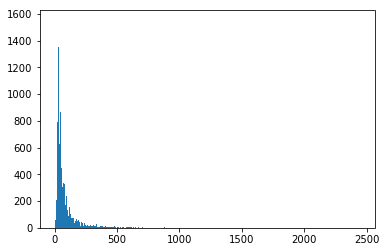

In [30]:
plt.hist(label_time,bins = 1000)
plt.show()

In [ ]:
###Readin Data

In [118]:
tryme2 = np.ones((5,4))

In [95]:
tryme2

array([[ 1.,  1.,  0.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  1.]])

In [121]:
tryme2[[2:4, ],2] = 0

In [79]:
a = np.tril(np.ones((3,3))*(np.array([1,2,3]).reshape(3,1))).flatten()
a[np.nonzero(a)]

array([ 1.,  2.,  2.,  3.,  3.,  3.])

In [96]:
x = [[i]*i for i in [1,2,4]]

In [98]:
x = sum(x,[])

In [99]:
x

[1, 2, 2, 4, 4, 4, 4]

In [111]:
4%3

1

In [127]:
group = 2
unit = 14
mtrx = np.zeros((unit, unit))
for i in range(int(unit/group)):
    sequence = list(np.arange(i, unit/group))
    #print(sequence)
    sequence = [int(j) for j in sequence if (j - i)%x[i] == 0]
    ##print(sequence)
    for index in sequence:
        mtrx[index*group:(index+1)*group,i*group:(i+1)*group] = 1

In [128]:
mtrx

array([[ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.],
       [ 1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.],
       [ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.],
       [ 1.,  1.,  1.,  1.,  0.,  0.,  0., 

In [136]:
block_tri(2,[1,2,4],14, mode = 'shift') == mtrx

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         

In [ ]:
torch.from_numpy(np.array()).type(torch.FloatTensor)

tryme = torch.Tensor([[1,2],[2,3]])

tryme

In [134]:
### Helper function
def block_tri(group_size,scale, num_units, mode = 'original'):
    '''
    group_size: the size of each group
    num_units: group_size x sum(scale)
    mode: the way of connection, original, shift, fully connect
    return: tensor mask
    '''
    mtrx = np.zeros((num_units, num_units))
    if mode == 'original':
        for i in range(num_units/group_size - 1):
            mtrx[i*group_size: , i*group_size:(i+1)*group_size] = 1
    elif mode == 'shift': 
        mtrx = np.zeros((num_units, num_units))
        for i in range(int(num_units/group_size)):
            refer_li = sum([[i]*i for i in scale],[])
            length = refer_li[i]
            sequence = list(np.arange(i, num_units/group_size))
            #print(sequence)
            sequence = [int(j) for j in sequence if (j - i)%length == 0]
            ##print(sequence)
            for index in sequence:
                mtrx[index*group_size:(index+1)*group_size,i*group_size:(i+1)*group_size] = 1
    return mtrx 

#def activate_index()

In [15]:
def activate_index(timestep, num_units, group_size, scale,index_li):
    '''
    timestep: the current timestep in a sequence
    num_units: dimension of hidden layer
    group_size: number of nodes in each group
    scale: the range of update frequency
    index_li: the index of each scale start point. dictionary. scale: position
    return: a matrix with 0 and 1. 1 for active rows
    '''
    activation_map = np.zeros((num_units,num_units))
    for i in scale:
        remain = timestep%i
        if remain == 0:
            index_temp = index_li[i]
            activation_map[index_temp*group_size:(index_temp+1)*group_size,:] = np.ones((group_size,num_units))
        else:
            index_temp = i - remain + index_li[i]
            activation_map[index_temp*group_size:(index_temp+1)*group_size,:] = np.ones((group_size,num_units))
    return torch.from_numpy(activation_map).float()
### make it a tensor

In [12]:
activate_index(7,14,2,[1,2,4],{1:0,2:1,4:3})

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 

In [32]:
a = torch.from_numpy(np.array([[1,2,3],[4,5,6]]))
b = torch.from_numpy(np.array([[2,3,4],[4,5,6]]))
c = a*b

In [33]:
c


  2   6  12
 16  25  36
[torch.LongTensor of size 2x3]

In [36]:
c[-2,]


  2
  6
 12
[torch.LongTensor of size 3]

In [ ]:
### Model
#forward
#cell_class, step
class Clock_NN(nn.Module):
    def __init__(self, scale, group_size = 1, activation_fun = F.relu, mean = 0, std = 0.1, input_dim = 48)
        '''
        scale: the updating frequency, a list. [1,2,4,8,16,32]
        group_size: the number of nodes in each scale, default is 1.
        activation_function
        mean: the mean of Gaussian distribution for initialize weights for hidden layer
        std: the standard devation of the Gaussian distribution for initialize weights for hidden layer
        input_dim: the feature dimension of each time step
        '''
        self.scale = scale
        self.group_size = group_size
        if mode = 'orginal':
            self.num_units = self.scale*self.group_size
        elif mode = 'shift':
            self.num_units = sum(self.scale)*self.group_size
            
        self.class_dim = 2
        self.input_dim = input_dim
        self.linear_h = self.Linear(self.num_units,self.num_units)
        self.linear_o = self.Linear(self.num_units,self.class_dim)
        self.linear_i = self.Linear(self.num_units,self.input_dim)
        self.activation_fun = activation_fun
        self.connect = torch.from_numpy(block_tri(self.group_size, self.scale, self.num_units)).float()
        self.time_step = 0
        self.index_li = {i:i-1 for i in self.scale}
        
        self.initial_weights(mean, std)
        
    def forward(self, sequence, hidden)#depends on what passed for model.train(), to be filled)
        '''
        sequence: number_feature x timestep matrix
        hidden: should be h0
        '''     
        hidden_output = []
        logit = []
        for i in range(1,len(sequence)+1):
            self.time_step += 1
            #backwards, want discharge/dead time aligns
            hidden = self.CW_RNN_Cell(sequence[-i], hidden)
            hidden_output.append(hidden)
            out = self.linear_o(hidden)
            logit.append(F.log_softmax(out))
        return hidden_output, logit
            
                
    def CW_RNN_Cell(self, x_input, hidden):
        '''
        x_input: number_feature x 1 vector, representing one time stamp
        hidden: output of the last cell, should be hidden_dim(i.e. num_units) x 1
        '''
        activate = activate_index(self.time_step, self.num_units, self.group_size, self.scale,self.index_li)
        ### TODO: add leakage
        hidden_next = self.linear_h(hidden)*self.connect*activate + self.linear_i(x_input)*activate
        hidden_next = self.activation_fun(hidden_next)
        return hidden_next

    def init_hidden(self, bsz):
        h0 = Variable(torch.zeros(self.num_units,1))
        return h0
        
    def initial_weights(self, mean, std):
        lin_layers = [self.linear_h, self.linear]
        for layer in lin_layers:
            layer.weight.data.normal_(mean, std**2)
            layer.bias.data.fill_(0)
    

In [41]:
torch.zeros(2,1)


 0
 0
[torch.FloatTensor of size 2x1]

In [ ]:
### Training
model = Clock_NN(scale, group_size = 1, activation_fun = F.relu, mean = 0, std = 0.1, input_dim = 48)

In [ ]:
def training_loop(num_epochs, model, criterion, optim):
    step = 1
    total_batches = int(len(training_set) / batch_size)

    for i in range(num_epochs):
        #model.train()      
        #define a data loader and one by one bzs =1
        ###DATALOADER
        model.zero_grad()     
        hidden= model.init_hidden()
        hidden, output = model(inputs, hidden)
         # batch_size, seq_len, hid --> b*s,h
        output = torch.stack(output, dim=0) #should be time_len x class_num
        target = target.view(len(sequence),-1) #target is Variable and scaled to the length of timestep
        lossy = criterion(output_flat, targets)
        lossy.backward()
        optim.step()

In [ ]:
### Evaluation